In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import seaborn as sns
from compress_pickle import load, dump
from statistics import mean, median
from c_means_clustering import network_c_means
from c_means_clustering_alt import network_c_means_alt
from copy import deepcopy
import itertools as it
import matplotlib.pyplot as plt
from math import log10
from ease import EASE

plt.style.use('bmh')

path = './files/'

def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

regulome_network_edges = pd.read_csv(filepath_or_buffer=path+'/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_graph = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids=False)
proteins = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).unique()

clusters_dict = open_pickle("c_means_leiden_clusters.gz")
msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')
msigdb_c3_tft_dict = {setid:genes for setid, genes in msigdb_c3_tft_dict.items() if len(genes) >= 5}

In [ ]:
# def leiden_clustering(graph, res, n_iter, beta=0.05):
#     return graph.community_leiden(objective_function='modularity',
#                             weights='PPV',
#                             resolution=res,
#                             beta=beta,
#                             n_iterations=n_iter)

# leiden_clusters = leiden_clustering(regulome_graph, 8, 20)
# clusters_dict = {n : set(regulome_graph.vs[node]['name'] for node in cluster) for (n, cluster) in enumerate(leiden_clusters) if len(cluster) > 5 and len(cluster) < 200}

# with open('./files/c_means_leiden_clusters.gz', 'wb') as file:
#     dump(clusters_dict, file, compression='infer')


In [14]:
path_len_dict = open_pickle("path_lengths_dict.gz")

In [15]:
for distance_metric in ['path_len']:
    for perc in [99.9]:
        if distance_metric == 'path_len':
            path_len = path_len_dict
        else:
            path_len = None
        results = network_c_means(regulome_graph, deepcopy(clusters_dict), 2, n_iter=1, optimize=True, percentile=perc, distance_measure=distance_metric, path_lengths=path_len, cores=8)

        with open(path+f"c_means_1iter_{distance_metric}_{int(perc*100)}.gz", 'wb') as file:
            dump(results, file, compression='infer')

<function path_length_dist at 0x7fc0c47f6980>
Iteration 1 of 1





























































100%|██████████| 15041/15041 [00:51<00:00, 293.87it/s]


Updating Clusters: percentile 99.9


In [20]:
results_pl_98 = open_pickle("c_means_1iter_path_len_980.gz")
results_pl_99 = open_pickle("c_means_1iter_path_len_990.gz")
results_pl_999 = open_pickle("c_means_1iter_path_len_9990.gz")

results_er_98 = open_pickle("c_means_1iter_edge_ratio_980.gz")
results_er_99 = open_pickle("c_means_1iter_edge_ratio_990.gz")
results_er_999 = open_pickle("c_means_1iter_edge_ratio_999.gz")
results_er_9995 = open_pickle("c_means_1iter_edge_ratio_9995.gz")
results_er_9999 = open_pickle("c_means_1iter_edge_ratio_9999.gz")

results_dict = {
    ('leiden', 0): results_pl_98[0][0],
    ('pl', 0.98): results_pl_98[0][1],
    ('pl', 0.99): results_pl_99[0][1],
    ('pl', 0.999): results_pl_999[0][1],
    ('er', 0.98): results_er_98[0][1],
    ('er', 0.99): results_er_99[0][1],
    ('er', 0.999): results_er_999[0][1],
    ('er', 0.9995): results_er_9995[0][1],
    ('er', 0.9999): results_er_9999[0][1],
}

In [21]:
def calc_jaccard_index(clusters):
    overlap_coefficients = list()

    for set_A, set_B in it.combinations(clusters, 2):
        ov_coeff = (len(set_A.intersection(set_B)))/(len(set_A.union(set_B)))
        overlap_coefficients.append(ov_coeff)
    return overlap_coefficients

def enrichment_ease(clusters, gene_set):
    enrichment_dict = dict()
    for (clusterid, cluster) in clusters.items():
        enrichment = EASE(query_set=cluster, genesets=gene_set, PT= regulome_graph.vcount())
        enrichment_dict[clusterid] = (enrichment, len(cluster), cluster) # maybe save this as a namedtuple with enrihcment and subgraph
    return enrichment_dict


def calculate_CCS(enrichment_dict, threshold=0.05):
    enrichments = list()
    for cluster in enrichment_dict.values():
        cluster = cluster[0]
        enriched = cluster[cluster['FDR'] < threshold]
        if enriched.empty:
            continue
        enrichments.append(enriched[:][['pathway_id', 'FDR']])
    n_enriched_clusters = len(enrichments)
    enriched_df = pd.concat(enrichments)
    avg_set_per_cluster = len(enriched_df) / n_enriched_clusters
    avg_cluster_per_set = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
    CCS = avg_set_per_cluster / avg_cluster_per_set

    return CCS, n_enriched_clusters, avg_set_per_cluster, avg_cluster_per_set

In [39]:
len(msigdb_c3_tft_dict)

1112

In [64]:
msigdb_c3_tft_jaccard = calc_jaccard_index([set(gene_set) for gene_set in msigdb_c3_tft_dict.values()])
mean(msigdb_c3_tft_jaccard)

0.013383749178390438

In [22]:
CCS_df = pd.DataFrame()


for params, clusters in results_dict.items():
    clusters = {clusterid:cluster for clusterid, cluster in clusters.items() if len(cluster) >= 5 and len(cluster) <= 200}
    print(f"{params}, {len(clusters)}")

    avg_jaccard_index = mean(calc_jaccard_index(clusters.values()))

    enrichment = enrichment_ease(clusters, msigdb_c3_tft_dict)
    CCS_values = calculate_CCS(enrichment, threshold=0.05)

    cluster_sizes = [len(cluster) for cluster in clusters.values()]
    CCS_df = pd.concat([CCS_df, 
                        pd.DataFrame({'d': params[0],
                                      'percen': params[1],
                                      'n_clusters': [len(clusters)],
                                      'avg_size': [mean(cluster_sizes)],
                                      'median_size': [median(cluster_sizes)],
                                      'avg_jaccard': [avg_jaccard_index],
                                      'n_enriched':[CCS_values[1]],
                                      '%_enriched': [(CCS_values[1]/len(clusters))*100],
                                      'avg_s/c': [CCS_values[2]],
                                      'avg_c/s':[CCS_values[3]],
                                      'Error': [CCS_values[2]+CCS_values[3]-2],
                                      'CCS': [CCS_values[0]]})])


('leiden', 0), 622


  0%|          | 0/15041 [07:46<?, ?it/s]


('pl', 0.98), 457
('pl', 0.99), 502
('pl', 0.999), 605
('er', 0.98), 464
('er', 0.99), 507
('er', 0.999), 608
('er', 0.9995), 608
('er', 0.9999), 608


In [25]:
CCS_df

,d,percen,n_clusters,avg_size,median_size,avg_jaccard,n_enriched,%_enriched,avg_s/c,avg_c/s,Error,CCS
0,leiden,0.0000,622,23.393891,18.0,0.000000,60,9.646302,3.766667,1.386503,3.153170,2.716667
0,pl,0.9800,457,49.339168,35.0,0.000772,57,12.472648,5.456140,1.517073,4.973214,3.596491
0,pl,0.9900,502,45.000000,31.0,0.000643,58,11.553785,4.068966,1.465839,3.534804,2.775862
0,pl,0.9990,605,34.297521,24.0,0.000323,61,10.082645,3.786885,1.434783,3.221668,2.639344
0,er,0.9800,464,53.359914,34.0,0.002613,120,25.862069,8.650000,2.369863,9.019863,3.650000
0,er,0.9900,507,43.968442,26.0,0.001184,112,22.090730,7.776786,2.155941,7.932726,3.607143
0,er,0.9990,608,29.567434,19.5,0.000243,73,12.006579,4.808219,1.632558,4.440777,2.945205
0,er,0.9995,608,29.567434,19.5,0.000243,73,12.006579,4.808219,1.632558,4.440777,2.945205
0,er,0.9999,608,29.567434,19.5,0.000243,73,12.006579,4.808219,1.632558,4.440777,2.945205


In [38]:
for i in CCS_df[CCS_df['d'] == "pl"].iterrows():
    print(i[1])

d                     pl
percen              0.98
n_clusters           457
avg_size       49.339168
median_size         35.0
avg_jaccard     0.000772
n_enriched            57
%_enriched     12.472648
avg_s/c          5.45614
avg_c/s         1.517073
Error           4.973214
CCS             3.596491
Name: 0, dtype: object
d                     pl
percen              0.99
n_clusters           502
avg_size            45.0
median_size         31.0
avg_jaccard     0.000643
n_enriched            58
%_enriched     11.553785
avg_s/c         4.068966
avg_c/s         1.465839
Error           3.534804
CCS             2.775862
Name: 0, dtype: object
d                     pl
percen             0.999
n_clusters           605
avg_size       34.297521
median_size         24.0
avg_jaccard     0.000323
n_enriched            61
%_enriched     10.082645
avg_s/c         3.786885
avg_c/s         1.434783
Error           3.221668
CCS             2.639344
Name: 0, dtype: object


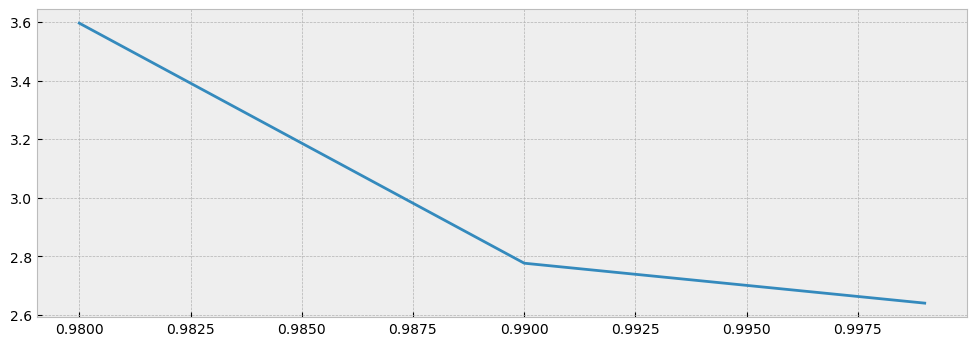

In [43]:
CCS_plot_pl = {row[1]['percen']:row[1]['CCS'] for row in CCS_df[CCS_df['d'] == "pl"].iterrows()}

fig, (ax1) = plt.subplots(1,1, figsize=(12,4))

ax1.plot(CCS_plot_pl.keys(), CCS_plot_pl.values())